# Model Training - Sustainable Development Goals

## Import packages

In [1]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.3 MB/s 
     |████████████████████████████████| 162 kB 63.5 MB/s 
     |████████████████████████████████| 182 kB 58.0 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 162 kB 63.1 MB/s 
     |████████████████████████████████| 158 kB 60.6 MB/s 
     |████████████████████████████████| 157 kB 58.5 MB/s 
     |████████████████████████████████| 157 kB 59.2 MB/s 
     |████████████████████████████████| 157 kB 59.2 MB/s 
     |████████████████████████████████| 157 kB 36.5 MB/s 
     |████████████████████████████████| 157 kB 62.4 MB/s 
     |████████████████████████████████| 157 kB 44.0 MB/s 
     |████████████████████████████████| 157 kB 44.3 MB/s 
     |████████████████████████████████| 156 kB 12.9 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=80

In [2]:
import numpy as np
import pandas as pd
import glob
import os
import time
import gdown 
import wandb

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import tensorflow as tf
from tensorflow import keras

## Download datasets

In [3]:
# download datasets for training, validation, and testing
url = "https://drive.google.com/drive/folders/1HeePd1hE7mW_IHMf-zlxTq5-jRRXzkKF"
gdown.download_folder(url, quiet=True)

['/content/datasets_sdg_tensorflow/test_set/42447712799448928/00000000.shard/00000000.snapshot',
 '/content/datasets_sdg_tensorflow/test_set/466067248607334852/00000000.shard/00000000.snapshot',
 '/content/datasets_sdg_tensorflow/test_set/6989444772274388257/00000000.shard/00000000.snapshot',
 '/content/datasets_sdg_tensorflow/test_set/8902485652377246535/00000000.shard/00000000.snapshot',
 '/content/datasets_sdg_tensorflow/test_set/13305300455137190166/00000000.shard/00000000.snapshot',
 '/content/datasets_sdg_tensorflow/test_set/14286881580522802405/00000000.shard/00000000.snapshot',
 '/content/datasets_sdg_tensorflow/test_set/14485610225892787304/00000000.shard/00000000.snapshot',
 '/content/datasets_sdg_tensorflow/test_set/dataset_spec.pb',
 '/content/datasets_sdg_tensorflow/test_set/snapshot.metadata',
 '/content/datasets_sdg_tensorflow/train_set/201201756575091391/00000000.shard/00000000.snapshot',
 '/content/datasets_sdg_tensorflow/train_set/2552275124572596049/00000000.shard/00

## Metrics

In [4]:
def compute_binary_metrics(y_test, y_preds, labels):
    metrics = {}.fromkeys(labels, None)
    for label in labels:
        metrics[label] = {}.fromkeys(["Accuracy", 'Recall', 'Precision', 'F1 Score', "ROC AUC"], None)

    for i, label in enumerate(labels):
        y_true = y_test[:, i]
        y_pred = y_preds[:, i].round()

        metrics[label]['Accuracy'] = accuracy_score(y_true, y_pred)
        metrics[label]['Recall'] = recall_score(y_true, y_pred)
        metrics[label]['Precision'] = precision_score(y_true, y_pred)
        metrics[label]['F1 Score'] = f1_score(y_true, y_pred)
        metrics[label]['ROC AUC'] = roc_auc_score(y_true, y_pred)

    metrics_data = pd.DataFrame(metrics).round(4)
    return metrics_data

Este é um problema de classificação multilabel, isso exige que as métricas que vamos calcular considerem este novo contexto, e portanto, são um pouco diferentes das que usualmente usamos em problemas multi-class ou binários. A fundamentação teórica dessas métricas podem ser encontradas [aqui](https://mmuratarat.github.io/2020-01-25/multilabel_classification_metrics), e abaixo estão suas definições:

In [5]:
def exact_match_ratio(y_true, y_pred):
    return np.all(y_pred == y_true, axis=1).mean()


# also called overall accuracy
def hamming_score(y_true, y_pred):
    accum = 0
    for i in range(y_true.shape[0]):
        accum += np.sum(np.logical_and(y_true[i], y_pred[i])) / np.sum(np.logical_or(y_true[i], y_pred[i]))
    return accum / y_true.shape[0]


# also called overall loss
def hamming_loss(y_true, y_pred):
    accum = 0
    for i in range(y_true.shape[0]):
        accum += np.size(y_true[i] == y_pred[i]) - np.count_nonzero(y_true[i] == y_pred[i])
    return accum/(y_true.shape[0] * y_true.shape[1])


def precision_overall(y_true, y_pred):
  accum = 0
  for i in range(y_true.shape[0]):
      if np.sum(y_pred[i]) == 0:
          continue
      accum += np.sum(np.logical_and(y_true[i], y_pred[i]))/ np.sum(y_pred[i])
  return accum / y_true.shape[0]


def recall_overall(y_true, y_pred):
  accum = 0
  for i in range(y_true.shape[0]):
      if np.sum(y_true[i]) == 0:
          continue
      accum += np.sum(np.logical_and(y_true[i], y_pred[i])) / np.sum(y_true[i])
  return accum / y_true.shape[0]


def f1_overall(y_true, y_pred):
    accum = 0
    for i in range(y_true.shape[0]):
        if (np.sum(y_true[i]) == 0) and (np.sum(y_pred[i]) == 0):
            continue
        accum += (2*np.sum(np.logical_and(y_true[i], y_pred[i])))/ (np.sum(y_true[i])+np.sum(y_pred[i]))
    return accum / y_true.shape[0]

In [6]:
def print_multilabel_metrics(y_true, y_pred):
    em_ratio = exact_match_ratio(y_true, y_pred)
    overall_accuracy = hamming_score(y_true, y_pred)
    overall_loss = hamming_loss(y_true, y_pred)
    precision = precision_overall(y_true, y_pred)
    recall = recall_overall(y_true, y_pred)
    f1 = f1_overall(y_true, y_pred)

    print("Exact Match\t\t= {:.4f}".format(em_ratio))
    print("Overall Accuracy\t= {:.4f}".format(overall_accuracy))
    print("Overall Loss\t\t= {:.4f}".format(overall_loss))
    print("Overall Precision\t= {:.4f}".format(precision))
    print("Overall Recall\t\t= {:.4f}".format(recall))
    print("Overall F1 Score\t= {:.4f}".format(f1))

## Train

### Text Vectorization

In [7]:
def build_text_vectorization_layer(train_set, output_sequence_length):
    
    # convert tensorflow train set to numpy train set
    X_train = np.array([])
    for data, label in train_set:
        X_train = np.concatenate((X_train, data.numpy()))
    
    max_vocabulary_size = 20000 # recommend to be 10000+

    text_vectorization = tf.keras.layers.TextVectorization(
        max_tokens=max_vocabulary_size,
        output_mode='int',
        output_sequence_length=output_sequence_length)

    # "adapt" the layer to the data (this is the same as "fit") 
    text_vectorization.adapt(X_train)
    
    return text_vectorization

### Class weights (for unbalancing issues)

Apesar de já termos realizado uma etapa de balanceamento do dataset, ainda podemos usar uma função de custo adaptada para considerar leves desbalanceamentos entre as classes. Essa função atribui pesos para cada classe no momento de calcular a *`binary_crossentropy` loss function*. O pesos de cada classe podem ser calculados automaticamente com a função `compute_class_weights`, ou simplesmente podemos passar os pesos manualmente para a função `get_weighted_loss`, que então retorna a função `binary_crosstropy` considerando os pesos que foram passados como parâmetros. 

In [8]:
def compute_class_weights(train_set):
    i = 0
    for X, y in train_set:
        if i == 0:
            y_train = y.numpy()
            i += 1
        
        y_train = np.concatenate((y_train, y.numpy()))
        
    n_classes = y_train.shape[1]
    weights = np.empty([n_classes, 2])
    for i in range(n_classes):
        weights[i] = compute_class_weight('balanced', classes=[0., 1.], y=y_train[:, i])
    return weights


# Weighted binary cross entropy loss function
# use custom loss function
# https://stackoverflow.com/questions/48485870/multi-label-classification-with-class-weights-in-keras
def get_weighted_loss(weights):
    def weighted_loss(y_train, y_pred):
        return keras.backend.mean((weights[:, 0] ** (1-y_train)) * (weights[:, 1] ** (y_train)) *\
                      keras.backend.binary_crossentropy(y_train, y_pred), axis=-1)
    return weighted_loss

Há 3 estratégias default disponíveis para ponderar as classes e lidar com desbalanceamentos entre elas, que são:

- Usar uma função de custo padrão e ponderar igualmente todas as classes;
- Usar uma função de custo customizada com pesos calculados automaticamente;
- Usar uma função de custo customizada com pesos calculados manualmente.

A função abaixo encapsula isso em um fluxo de condicionais:

In [9]:
def get_class_weight(train_set, class_weight_kind="balanced"):
    if class_weight_kind is None:
        class_weights = None
        
    elif class_weight_kind == "balanced":
        class_weights = compute_class_weights(train_set)
        
    elif class_weight_kind == "two-to-one":
        class_weights = np.zeros((16, 2))
        class_weights[:, 0] = 1.
        class_weights[:, 1] = 2.
    
    return class_weights

### Load datasets

In [10]:
# load pre-saved tensorflow datasets
def load_datasets():
    
    train_set = tf.data.experimental.load("./datasets_sdg_tensorflow/train_set")
    valid_set = tf.data.experimental.load("./datasets_sdg_tensorflow/valid_set")
    test_set = tf.data.experimental.load("./datasets_sdg_tensorflow/test_set")
    
    return train_set, valid_set, test_set

### Logs

Para realizar o log de métricas e artefatos, são utilizadas duas funções:

- `get_run_logdir`: armazena dados de treinamento extraídos de `callbacks` do TensorFlow
- `logging`: salva o modelo e armazena métricas de performance no WandB. Para usar esta função, você deve estar logado na sua conta do WandB

In [ ]:
# define folder for artifact persistence
def get_run_logdir(root_logdir):
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [ ]:
# To run this cell, you must log in to your WandB account
def logging(model, valid_set, test_set, model_dir):
    # Evaluation
    bce, accuracy = model.evaluate(test_set)
    valid_bce, valid_accuracy = model.evaluate(valid_set)
    
    # save model
    model.save(model_dir)
    
    # Logging metrics
    y_pred = ((model.predict(test_set) > 0.5) + 0)
    for i, (X, y) in enumerate(test_set):
        if i > 0:
            y_true = np.concatenate((y_true, y.numpy()))
        else:
            y_true = y.numpy()
            
    em_ratio = exact_match_ratio(y_true, y_pred)
    overall_accuracy = hamming_score(y_true, y_pred)
    overall_loss = hamming_loss(y_true, y_pred)
    precision = precision_overall(y_true, y_pred)
    recall = recall_overall(y_true, y_pred)
    f1 = f1_overall(y_true, y_pred)
    
    wandb.log({
        "Accuracy": accuracy,
        "Validation Accuracy": valid_accuracy,
        "Loss": bce,
        "Validation Loss": valid_bce,
        "Exact Match Ratio": em_ratio,
        "Hamming Score": overall_accuracy,
        "Hamming Loss": overall_loss,
        "Overall Precision": precision,
        "Overall Recall": recall,
        "Overall F1": f1
    })

### Build Model

In [11]:
def build_model(n_outputs, text_vectorization, optimizer, loss, units=50, 
                dropout=0.25, constraint=None, n_hidden=2):
    
    # add 1 for the padding token
    vocabulary_size = len(text_vectorization.get_vocabulary()) + 1
    number_out_of_vocabulary_buckets = 1  # default value for the text vectorizarization layer, do not change
    
    # set embedding dimensions to the number of units
    embed_size = units
    
    # same droupout and constraint rate for the recurrent states
    recurrent_dropout = 0 # must be set to 0 when using GPU
    recurrent_constraint = constraint
    
    # instantiate the model and add text vectorization and embedding layer
    model = keras.models.Sequential()
    model.add(text_vectorization)
    model.add(keras.layers.Embedding(input_dim=vocabulary_size + number_out_of_vocabulary_buckets, 
                                     output_dim=embed_size, mask_zero=True, input_shape=[None]))
    
    # add hidden layers
    for layer in range(n_hidden-1):
        model.add(keras.layers.GRU(units, return_sequences=True, 
                                   dropout=dropout, recurrent_dropout=recurrent_dropout,
                                   kernel_constraint=constraint, recurrent_constraint=recurrent_constraint))
    
    model.add(keras.layers.GRU(units, dropout=dropout, recurrent_dropout=recurrent_dropout,
                               kernel_constraint=constraint, recurrent_constraint=recurrent_constraint))
    
    # add output layer
    model.add(keras.layers.Dense(n_outputs, activation="sigmoid"))
    
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    return model

### Train Model

In [12]:
def train_model(train_set, valid_set, test_set, class_weight_kind, optimizer, learning_rate, 
                units, dropout, constraint, n_hidden, output_sequence_length, epochs=50, log=False):
    
    # train preparation
    text_vectorization_layer = build_text_vectorization_layer(train_set, output_sequence_length)
    
    # Loss function
    class_weights = get_class_weight(train_set, class_weight_kind)
    
    if class_weight_kind is None:
        loss = "binary_crossentropy"
    elif (class_weight_kind == "balanced") or (class_weight_kind == "two-to-one"):
        loss = get_weighted_loss(class_weights)
        
    # Optimizer
    if optimizer == "Nadam":
        optimizer = keras.optimizers.Nadam(learning_rate, clipnorm=1)
    elif optimizer == "Adam":
        optimizer = keras.optimizers.Adam(learning_rate, clipnorm=1)
    elif optimizer == "RMSprop":
        optimizer = keras.optimizers.RMSprop(learning_rate, clipnorm=1, centered=True)
        
    n_outputs = 16
    model = build_model(n_outputs, text_vectorization_layer, optimizer, loss, units, 
                        dropout, constraint, n_hidden)
    
    # Define callbacks
    root_logdir = os.path.join(os.curdir, "my_logs")
    run_logdir = get_run_logdir(root_logdir)
    model_dir = os.path.join(run_logdir, "model")

    tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                      mode="max", patience=2, 
                                                      restore_best_weights=True)

    callbacks = [tensorboard_cb, early_stopping_cb]
    
    # Fit model
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=callbacks)
    
    # Logging metrics
    if log:
        logging(model, valid_set, test_set, model_dir)
    else:
        # Evaluation
        bce, accuracy = model.evaluate(test_set)
        valid_bce, valid_accuracy = model.evaluate(valid_set)

    return model, history

Um exemplo de como rodar uma única iteração de treino seria o seguinte:

```python
train_set, valid_set, test_set = load_datasets()

constraint = keras.constraints.MaxNorm(max_value=2)
class_weight_kind = None
output_sequence_length = 70
optimizer = "RMSprop"
units = 70
dropout = 0.3
n_hidden = 1
epochs = 5

initial_learning_rate = 0.01
decay_steps = 6309 # number of steps per epoch
rate = 2
decay_rate = 1/rate  # decrease the learning by a factor of 'rate' every 'decay_steps'
lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate
)

learning_rate = lr_scheduler

model, history = train_model(train_set, valid_set, test_set, class_weight_kind, 
                             optimizer, learning_rate, units, dropout, constraint, 
                             n_hidden, output_sequence_length, epochs)
```

### Fine Tuning of the model using best parameter set found by GS-CV

In [13]:
train_set, valid_set, test_set = load_datasets()

In [14]:
for i, (title, target) in enumerate(test_set):
    if i == 0:
        y_true = target
    else:
        y_true = np.concatenate((y_true, target.numpy()))

labels = ["SDG " + str(i+1) for i in range(16)]

---
#### Evaluation of model with 1 hidden layer

```python
constraint = keras.constraints.MaxNorm(max_value=5)
class_weight_kind = "two-to-one"
output_sequence_length = 50
optimizer = "RMSprop"
units = 50
dropout = 0.3
n_hidden = 1
epochs = 6

initial_learning_rate = 0.01
decay_steps = 6309 # number of steps per epoch
rate = 3
decay_rate = 1/rate  # decrease the learning by a factor of 'rate' every 'decay_steps'
lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate
)

learning_rate = lr_scheduler

model, history = train_model(train_set, valid_set, test_set, class_weight_kind, 
                             optimizer, learning_rate, units, dropout, constraint, 
                             n_hidden, output_sequence_length, epochs)
```

In [ ]:
# Download and load model
url = "https://drive.google.com/drive/folders/1RONqQr4Rpt4yj8Dr_T20qN_no1erw4rw"
gdown.download_folder(url, quiet=True)

['/content/model_1/variables/variables.data-00000-of-00001',
 '/content/model_1/variables/variables.index',
 '/content/model_1/keras_metadata.pb',
 '/content/model_1/saved_model.pb']

In [ ]:
weights = get_class_weight(train_set, "two-to-one")
model1 = tf.keras.models.load_model("model_1", 
                                   custom_objects={"weighted_loss": get_weighted_loss(weights)})

In [ ]:
y_pred = (model1.predict(test_set) > 0.5) + 0

In [ ]:
print_multilabel_metrics(y_true, y_pred)

Exact Match		= 0.4060
Overall Accuracy	= 0.6411
Overall Loss		= 0.0725
Overall Precision	= 0.7660
Overall Recall		= 0.7284
Overall F1 Score	= 0.7173


In [ ]:
compute_binary_metrics(y_true, y_pred, labels)

,SDG 1,SDG 2,SDG 3,SDG 4,SDG 5,SDG 6,SDG 7,SDG 8,SDG 9,SDG 10,SDG 11,SDG 12,SDG 13,SDG 14,SDG 15,SDG 16
Accuracy,0.9151,0.9461,0.9263,0.9568,0.9454,0.9414,0.9463,0.8855,0.8880,0.9107,0.9291,0.9177,0.9252,0.9533,0.9273,0.9266
Recall,0.6549,0.7497,0.6057,0.7846,0.7446,0.7137,0.7786,0.6450,0.5133,0.6511,0.6120,0.6044,0.5975,0.7889,0.6390,0.6323
Precision,0.6575,0.8014,0.7605,0.8568,0.8388,0.7982,0.7818,0.6641,0.5875,0.6409,0.7738,0.6945,0.7486,0.8298,0.7459,0.7493
F1 Score,0.6562,0.7747,0.6743,0.8191,0.7889,0.7536,0.7802,0.6544,0.5479,0.6460,0.6834,0.6463,0.6646,0.8088,0.6883,0.6858
ROC AUC,0.8034,0.8617,0.7891,0.8830,0.8610,0.8439,0.8741,0.7895,0.7292,0.7995,0.7932,0.7833,0.7846,0.8829,0.8039,0.8008


---
#### Evaluation of Model with 2 hidden layers

```python
constraint = keras.constraints.MaxNorm(max_value=5)
class_weight_kind = "two-to-one"
output_sequence_length = 50
optimizer = "RMSprop"
units = 50
dropout = 0.3
n_hidden = 2
epochs = 6

initial_learning_rate = 0.01
decay_steps = 6309 # number of steps per epoch
rate = 3
decay_rate = 1/rate  # decrease the learning by a factor of 'rate' every 'decay_steps'
lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate
)

learning_rate = lr_scheduler

model, history = train_model(train_set, valid_set, test_set, class_weight_kind, 
                             optimizer, learning_rate, units, dropout, constraint, 
                             n_hidden, output_sequence_length, epochs)
```

In [15]:
# Download and load model
url = "https://drive.google.com/drive/folders/1DC0eVpkmHGCQJq2EOwyjINjjrlFxNKcz"
gdown.download_folder(url, quiet=True)

['/content/model_2/variables/variables.data-00000-of-00001',
 '/content/model_2/variables/variables.index',
 '/content/model_2/keras_metadata.pb',
 '/content/model_2/saved_model.pb']

In [16]:
weights = get_class_weight(train_set, "two-to-one")
model2 = tf.keras.models.load_model("model_2", 
                                   custom_objects={"weighted_loss": get_weighted_loss(weights)})

In [17]:
y_pred = (model2.predict(test_set) > 0.5) + 0

In [18]:
print_multilabel_metrics(y_true, y_pred)

Exact Match		= 0.4047
Overall Accuracy	= 0.6413
Overall Loss		= 0.0736
Overall Precision	= 0.7641
Overall Recall		= 0.7327
Overall F1 Score	= 0.7184


In [19]:
compute_binary_metrics(y_true, y_pred, labels)

,SDG 1,SDG 2,SDG 3,SDG 4,SDG 5,SDG 6,SDG 7,SDG 8,SDG 9,SDG 10,SDG 11,SDG 12,SDG 13,SDG 14,SDG 15,SDG 16
Accuracy,0.9159,0.9460,0.9245,0.9553,0.9429,0.9391,0.9443,0.8855,0.8855,0.9082,0.9282,0.9188,0.9254,0.9521,0.9251,0.9257
Recall,0.6547,0.7377,0.6042,0.7997,0.7528,0.7287,0.7754,0.6423,0.5202,0.6648,0.6106,0.5932,0.5998,0.7923,0.6478,0.6455
Precision,0.6619,0.8088,0.7480,0.8349,0.8162,0.7734,0.7712,0.6648,0.5740,0.6253,0.7673,0.7071,0.7487,0.8193,0.7266,0.7358
F1 Score,0.6583,0.7716,0.6684,0.8169,0.7832,0.7504,0.7733,0.6534,0.5458,0.6444,0.6800,0.6452,0.6660,0.8056,0.6849,0.6877
ROC AUC,0.8037,0.8566,0.7874,0.8886,0.8630,0.8490,0.8716,0.7885,0.7307,0.8039,0.7921,0.7791,0.7857,0.8837,0.8064,0.8059


In [20]:
def compute_binary_metrics(y_test, y_preds, labels):
    metrics = {}.fromkeys(labels, None)
    for label in labels:
        metrics[label] = {}.fromkeys(["Acurácia", "Precisão", "Recall", "F1-Score", "ROC AUC"], None)

    for i, label in enumerate(labels):
        y_true = y_test[:, i]
        y_pred = y_preds[:, i].round()

        metrics[label]['Acurácia'] = accuracy_score(y_true, y_pred)
        metrics[label]['Precisão'] = precision_score(y_true, y_pred)
        metrics[label]['Recall'] = recall_score(y_true, y_pred)
        metrics[label]['F1-Score'] = f1_score(y_true, y_pred)
        metrics[label]['ROC AUC'] = roc_auc_score(y_true, y_pred)

    metrics_data = pd.DataFrame(metrics).round(4)
    return metrics_data

In [21]:
binary_metrics = compute_binary_metrics(y_true, y_pred, labels)

In [22]:
binary_metrics = binary_metrics.rename(
    columns={'SDG 1':"ODS 1", 'SDG 2':"ODS 2", 'SDG 3':"ODS 3", 
             'SDG 4':"ODS 4", 'SDG 5':"ODS 5", 'SDG 6':"ODS 6", 
             'SDG 7':"ODS 7", 'SDG 8':"ODS 8", 'SDG 9':"ODS 9", 
             'SDG 10':"ODS 10", 'SDG 11':"ODS 11", 'SDG 12':"ODS 12", 
             'SDG 13':"ODS 13", 'SDG 14':"ODS 14", 'SDG 15':"ODS 15", 
             'SDG 16':"ODS 16"})

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
plt.style.use('fivethirtyeight')

In [25]:
binary_metrics.values

array([[0.9159, 0.946 , 0.9245, 0.9553, 0.9429, 0.9391, 0.9443, 0.8855,
        0.8855, 0.9082, 0.9282, 0.9188, 0.9254, 0.9521, 0.9251, 0.9257],
       [0.6619, 0.8088, 0.748 , 0.8349, 0.8162, 0.7734, 0.7712, 0.6648,
        0.574 , 0.6253, 0.7673, 0.7071, 0.7487, 0.8193, 0.7266, 0.7358],
       [0.6547, 0.7377, 0.6042, 0.7997, 0.7528, 0.7287, 0.7754, 0.6423,
        0.5202, 0.6648, 0.6106, 0.5932, 0.5998, 0.7923, 0.6478, 0.6455],
       [0.6583, 0.7716, 0.6684, 0.8169, 0.7832, 0.7504, 0.7733, 0.6534,
        0.5458, 0.6444, 0.68  , 0.6452, 0.666 , 0.8056, 0.6849, 0.6877],
       [0.8037, 0.8566, 0.7874, 0.8886, 0.863 , 0.849 , 0.8716, 0.7885,
        0.7307, 0.8039, 0.7921, 0.7791, 0.7857, 0.8837, 0.8064, 0.8059]])

In [26]:
from matplotlib.ticker import Formatter, FuncFormatter

def format_(x, pos):
  return re.sub("\.", ",", str(round(x,1)))
formatter = FuncFormatter(format_)

In [27]:
binary_metrics1 = binary_metrics.iloc[:, :8]
binary_metrics2 = binary_metrics.iloc[:, 8:]

In [28]:
import re

values1 = binary_metrics1.values
values_str1 = []
for value in values1:
  values_str1.append([re.sub("\.", ",", str(metric)) for metric in value])

values2 = binary_metrics2.values
values_str2 = []
for value in values2:
  values_str2.append([re.sub("\.", ",", str(metric)) for metric in value])

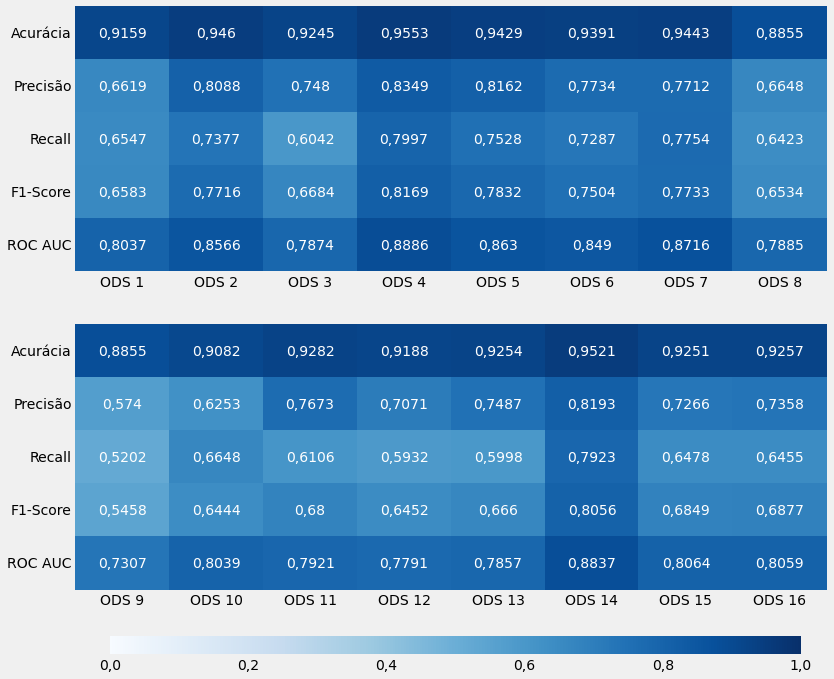

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
ax[0].tick_params(axis="x", labelsize=14)
ax[1].tick_params(axis="x", labelsize=14)

# [.12, .92, .8, .025] bar coordinates -> top
# [.12, -.02, .8, .025] bar coordinates -> bottom
cbar_ax = fig.add_axes([.12, -.02, .8, .025])

sns.heatmap(binary_metrics1, annot=values_str1, ax=ax[0], fmt="s", cmap="Blues", 
            vmin=0, vmax=1, cbar_kws={"format":formatter, "orientation": "horizontal"}, cbar_ax=cbar_ax)

sns.heatmap(binary_metrics2, annot=values_str2, ax=ax[1], fmt="s", cmap="Blues", 
            vmin=0, vmax=1, cbar_kws={"format":formatter, "orientation": "horizontal"}, cbar_ax=cbar_ax)

# plt.tight_layout()
plt.savefig("binary_metrics_bottom_transparent.png", dpi=400, bbox_inches="tight", transparent=True)

gerar heatmap

ressaltar melhor/pior acurácia
(gerar imagem com pandas)

---
**Final Results**

As you can see, the second model performed slightly better than the first one. The only difference between them, is their archicteture. While the first model uses 1 hidden layer, the second one uses 2.

Besides that, the parameter set is slighly different than that found looking up the sweeps table. The differences are listed below:

1. The recurrent dropout rate is set to 0, because in order to use GPUs, it cannot be differente than zero. The recurrent dropout rate used in the Sweeps were 0.3.

2. In Sweeps, the best model had `units=60` and `output_sequence_length=50`. It is good practice to set these values to be equal. Therefore, in the final model `units=output_sequence_length=50`

3. The model found using Sweeps had no regularization regarding the weights of the model. To deal with the additional overfit that may rise due to the fact that we are not using recurrent dropout anymore, we also added a weight constraint `keras.constraints.MaxNorm(max_value=5)` in the final model.

4. To stabilize the results, we used a exponential learning rate scheduler to train the final model.



Regarding the final results, we must choose one of the two models shown above. Considerations are:

1. The model with 1 hidden layer trains and predicts much faster (\~72s per epoch) than the model with 2 hidden layers (\~104s per epoch).
2. The model with 2 hidden layers performs slightly better and has a recall rate considerably greater.

Since we are not using this model in production, speed is not so important. Based on that, we are going to stick with the model with two hidden layers.

## Hyperparameter Tuning with Sweeps

In [ ]:
sweep_config = {
  "name" : "SDG-title-classification",
  "method" : "random",
  "metric": {
      "name": "Accuracy",
      "goal": "maximize"
  }
}

parameters_dict = {
    "learning_rate": {
        "values": [1e-3, 2e-3, 3e-3, 4e-3, 5e-3]
    },
    "weight_constraint": {
        "values": [None, 1., 3., 5.]
    },
    "optimizer": {
        "values": ["adam", "RMSprop", "nadam"]
    },
    "dropout": {
        "values": [0.2, 0.3, 0.4]
    },
    "units": {
        "values": [20, 30, 40, 50, 60]
    },
    "epochs": {
        "values": [6, 8, 10]
    },
    "output_sequence_length": {
        "values": [20, 30, 40]
    },
    "class_weight_kind": {
        "values": ["balanced", "two-to-one", None]
    },
    "n_hidden": {
        "values": [1, 2, 3]
    }
}

sweep_config["parameters"] = parameters_dict

In [ ]:
def sweep_train(config_defaults=None):
    
    wandb.init(config=config_defaults)
    wandb.config.architecture_name = "RNN"
    wandb.config.dataset_name = "SDG-titles"
    
    train_set, valid_set, test_set = load_datasets()
    
    config = wandb.config
    output_sequence_length = config.output_sequence_length
    units = config.units
    dropout = config.dropout
    epochs = config.epochs
    optimizer = config.optimizer
    class_weight_kind = config.class_weight_kind
    n_hidden = config.n_hidden
    weight_constraint = config.weight_constraint
    learning_rate = config.learning_rate
    
    if weight_constraint is None:
        constraint = None
    else:
        constraint = keras.constraints.MaxNorm(max_value=wandb.config.weight_constraint)
        
    train_model(train_set, valid_set, test_set, class_weight_kind, optimizer, learning_rate, 
                units, dropout, constraint, n_hidden, output_sequence_length, epochs, log=True)

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="SDG-title-classification")

In [ ]:
n_runs = 10
wandb.agent(sweep_id, function=sweep_train, count=n_runs)

## Appendix

### TextVectorization Layer

*Note: This code is just a variation of the source code from the text vectorization layer. In fact, the text vectorization layer developed in this section is more flexible in some aspects than that from TensorFlow itself.*


The `TextVectorization` layer is comprised of two main operations, namely: text preprocessing, and vocabulary construction, and text vectorization.

- **text preprocessing**: Operations of this component are carried out in the `preprocess` function, they are: 
    1. substring (we probably can tell the sentiment of a review in the first 300 characters.
    2. lowercase
    3. remove special commands
    4. keep only letters
    5. split the words (or stemmers, in this case), this is equivalent to perform tokenization
    6. sentence padding. This guarantees that all sentences will be fed to the model with the same size. Used for consistency.
- **Vocabulary construction**: Vocabulary construction is the action of form a vocabulary from a corpus. The function `get_vocabulary` is reponsible for that.
- **Text vectorization**: text is vectorized with `StaticVocabularyTable` function. `StaticVocabularyTable` maps each word to a unique id. Look at the following example:

```python
vocabulary= ["cat", "dog", "is", "not", "a"]
indices = tf.range(len(vocabulary), dtype=tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocabulary, indices)
n_oov_buckets = 2  # supports up to 2 extra categories not listed in the vocabulary 
table = tf.lookup.StaticVocabularyTable(table_init, n_oov_buckets)

sentence_example = tf.constant(["a", "cat", "is", "not", "a", "dog"])
table.lookup(sentence_example)
# <tf.Tensor: shape=(6,), dtype=int64, numpy=array([4, 0, 2, 3, 4, 1])>
```

**Text Preprocessing**

```python
def preprocess(X_batch, n_words=50):
    # All sentences must have the same shape
    shape = tf.shape(X_batch) * tf.constant([1, 0]) + tf.constant([0, n_words])
    
    # preprocess the texts
    Z = tf.strings.substr(X_batch, 0, 300)
    Z = tf.strings.lower(Z)
    Z = tf.strings.regex_replace(Z, b"<br\\s*/?>", b" ")
    Z = tf.strings.regex_replace(Z, b"[^a-z]", b" ")
    Z = tf.strings.split(Z)
    return Z.to_tensor(shape=shape, default_value=b"<pad>")

X_example = tf.constant(["a cat is not a dog", "dogs are playful"])
preprocess(X_example)
```

**Vocabulary Construction**

```python
from collections import Counter

def get_vocabulary(data_sample, max_size=1000):
    preprocessed_reviews = preprocess(data_sample).numpy()
    counter = Counter()
    for words in preprocessed_reviews:
        for word in words:
            if word != b"<pad>":
                counter[word] += 1
    return [b"<pad>"] + [word for word, count in counter.most_common(max_size)]

X_example = tf.constant(["a cat is not a dog", "dogs are playful"])
get_vocabulary(X_example)
```

**Text Vectorization**

Now we are ready to create the `TextVectorization` layer class. Its constructor just saves the hyperparameters (`max_vocabulary_size` and `n_oov_buckets`). Before we can use this layer, we need to adapt it to the dataset by calling `adapt()` and passing it a `data_sample` (a sample, or the full training set). 

The `adapt()` method computes the vocabulary using the `get_vocabulary()` function, then it builds a `StaticVocabularyTable`. The `call()` method preprocesses the reviews to get a padded list of words for each review, then it uses the `StaticVocabularyTable` to lookup the index of each word in the vocabulary:

```python
class TextVectorization(keras.layers.Layer):
    def __init__(self, max_vocabulary_size=1000, n_oov_buckets=100, dtype=tf.string, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.max_vocabulary_size = max_vocabulary_size
        self.n_oov_buckets = n_oov_buckets

    def adapt(self, data_sample):
        self.vocab = get_vocabulary(data_sample, self.max_vocabulary_size)
        words = tf.constant(self.vocab)
        word_ids = tf.range(len(self.vocab), dtype=tf.int64)
        vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
        self.table = tf.lookup.StaticVocabularyTable(vocab_init, self.n_oov_buckets)
        
    def call(self, inputs):
        preprocessed_inputs = preprocess(inputs)
        return self.table.lookup(preprocessed_inputs)
```

To use it in a model, adapt the layer, passing it the vocabulary size and the number of out-of-vocabulary buckets. Then, the layer is already for use, place it right before the `Embedding` layer:

```python
max_vocabulary_size = 10000
n_oov_buckets = 100

text_vectorization = TextVectorization(max_vocabulary_size, n_oov_buckets,
                                       input_shape=[])
text_vectorization.adapt(X_train)
```